<a href="https://colab.research.google.com/github/sriman99/disease-predictor/blob/main/Potato_Diesease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import pickle

In [2]:
from google.colab import drive
drive.mount('/content/drive')
IMAGE_SIZE = 224
BATCH_SIZE = 32
CHANNELS = 3
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/POTATO DISEASE',
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 1862 files belonging to 3 classes.


In [3]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [4]:
len(dataset)

59

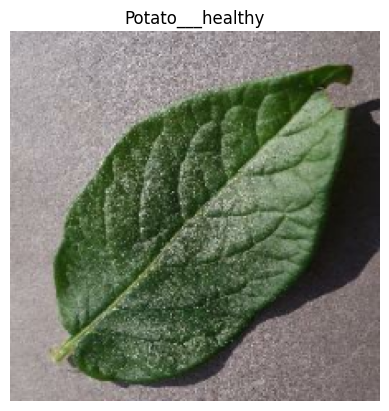

In [5]:
for image_batch,label_batch in dataset.take(1):
  plt.imshow(image_batch[0].numpy().astype("uint8"))
  plt.title(class_names[label_batch[1]])
  plt.axis("off")
  # print(image_batch[0].shape)
  # print(label_batch.numpy())



In [6]:
Epoches = 10


In [7]:
train_size = 0.8
len(dataset)*train_size


47.2

In [8]:
train_ds = dataset.take(47)
len(train_ds)

47

In [9]:

test_ds = dataset.skip(47)
len(test_ds)

12

In [10]:
valid_size = 0.1
len(dataset)*valid_size


5.9

In [11]:
val_ds = dataset.take(5)
len(val_ds)

5

In [12]:
test_ds = dataset.skip(5)
len(test_ds)

54

In [13]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split =0.1,test_split = 0.1,shuffle = True,shuffle_size =100000):
  if shuffle:
    ds=ds.shuffle(shuffle_size,seed = 15)

  train_size = int(train_split*len(ds))
  val_size = int(val_split*len(ds))
  test_size = int(test_split*len(ds))
  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)



  return train_ds,val_ds,test_ds

In [14]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [15]:
len(train_ds)

47

In [16]:
len(val_ds)

5

In [17]:
len(test_ds)

7

In [18]:
#implementing prefetch to reduce the time too access
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)


In [19]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [20]:
#Data Augmentation for the rotation,contrast of images
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomContrast(0.2)
])

In [28]:
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation = 'relu',input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation = 'relu'),
    layers.Dense(n_classes,activation = 'softmax'),
])

model.build(input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS))


In [29]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 224, 224, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 224, 224, 3)         0         
                                                                 
 conv2d_9 (Conv2D)           (32, 222, 222, 32)        896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (32, 111, 111, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (32, 109, 109, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (32, 54, 54, 64)          0         
 ng2D)                                                

In [33]:
model.compile(
    optimizer ='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy'],
)

In [34]:
history = model.fit(
    train_ds,
    epochs = Epoches,
    validation_data =val_ds,
    batch_size = BATCH_SIZE,
    verbose = 1,
    shuffle = True,


)

Epoch 1/10
47/47 [==============================] - 312s 4s/step - loss: 1.4694 - accuracy: 0.4874 - val_loss: 0.8038 - val_accuracy: 0.5750
Epoch 2/10
47/47 [==============================] - 166s 4s/step - loss: 0.6748 - accuracy: 0.6649 - val_loss: 0.7690 - val_accuracy: 0.6313
Epoch 3/10
47/47 [==============================] - 163s 3s/step - loss: 0.4867 - accuracy: 0.7919 - val_loss: 0.7394 - val_accuracy: 0.6562
Epoch 4/10
47/47 [==============================] - 163s 3s/step - loss: 0.4721 - accuracy: 0.7945 - val_loss: 0.2159 - val_accuracy: 0.9438
Epoch 5/10
47/47 [==============================] - 161s 3s/step - loss: 0.2801 - accuracy: 0.8863 - val_loss: 0.4057 - val_accuracy: 0.8375
Epoch 6/10
47/47 [==============================] - 163s 3s/step - loss: 0.3512 - accuracy: 0.8584 - val_loss: 0.2884 - val_accuracy: 0.8938
Epoch 7/10
47/47 [==============================] - 161s 3s/step - loss: 0.2612 - accuracy: 0.8876 - val_loss: 0.1794 - val_accuracy: 0.9250
Epoch 8/10
47

In [35]:
scores = model.evaluate(test_ds)

7/7 [==============================] - 26s 2s/step - loss: 0.1457 - accuracy: 0.9375


In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


Text(0.5, 1.0, 'Training and validation accuracy')

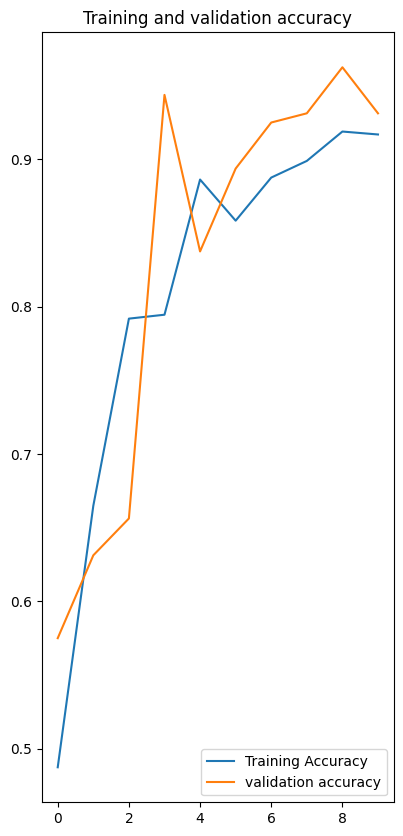

In [38]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(range(Epoches),acc , label = 'Training Accuracy')
plt.plot(range(Epoches),val_acc , label = 'validation accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and validation accuracy')

first image to predict
actual label Potato___Late_blight
1/1 [==============================] - 1s 827ms/step
Predicted image  Potato___Early_blight


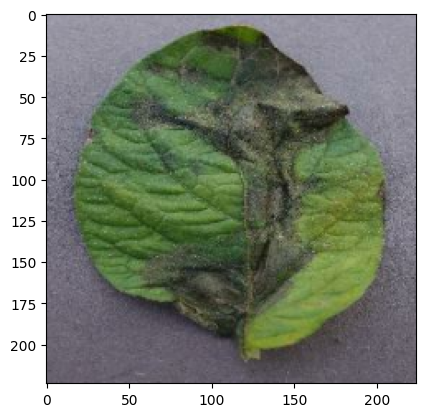

In [44]:
# Check the prdictions
import numpy as np
for images_batch,labels_batch in test_ds.take(1):
  first_image = images_batch[0].numpy().astype("uint8")
  first_label = labels_batch[0].numpy()
  print("first image to predict")
  plt.imshow(first_image)
  print("actual label",class_names[first_label])
  batch_prediction = model.predict(images_batch)
  print("Predicted image ",class_names[np.argmax(batch_prediction[0])])


In [45]:
 def predict(model,img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array,0)
  predictions = model.predict(img_array)
  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100*(np.max(predictions[0])),2)
  return predicted_class,confidence

1/1 [==============================] - 0s 56ms/step


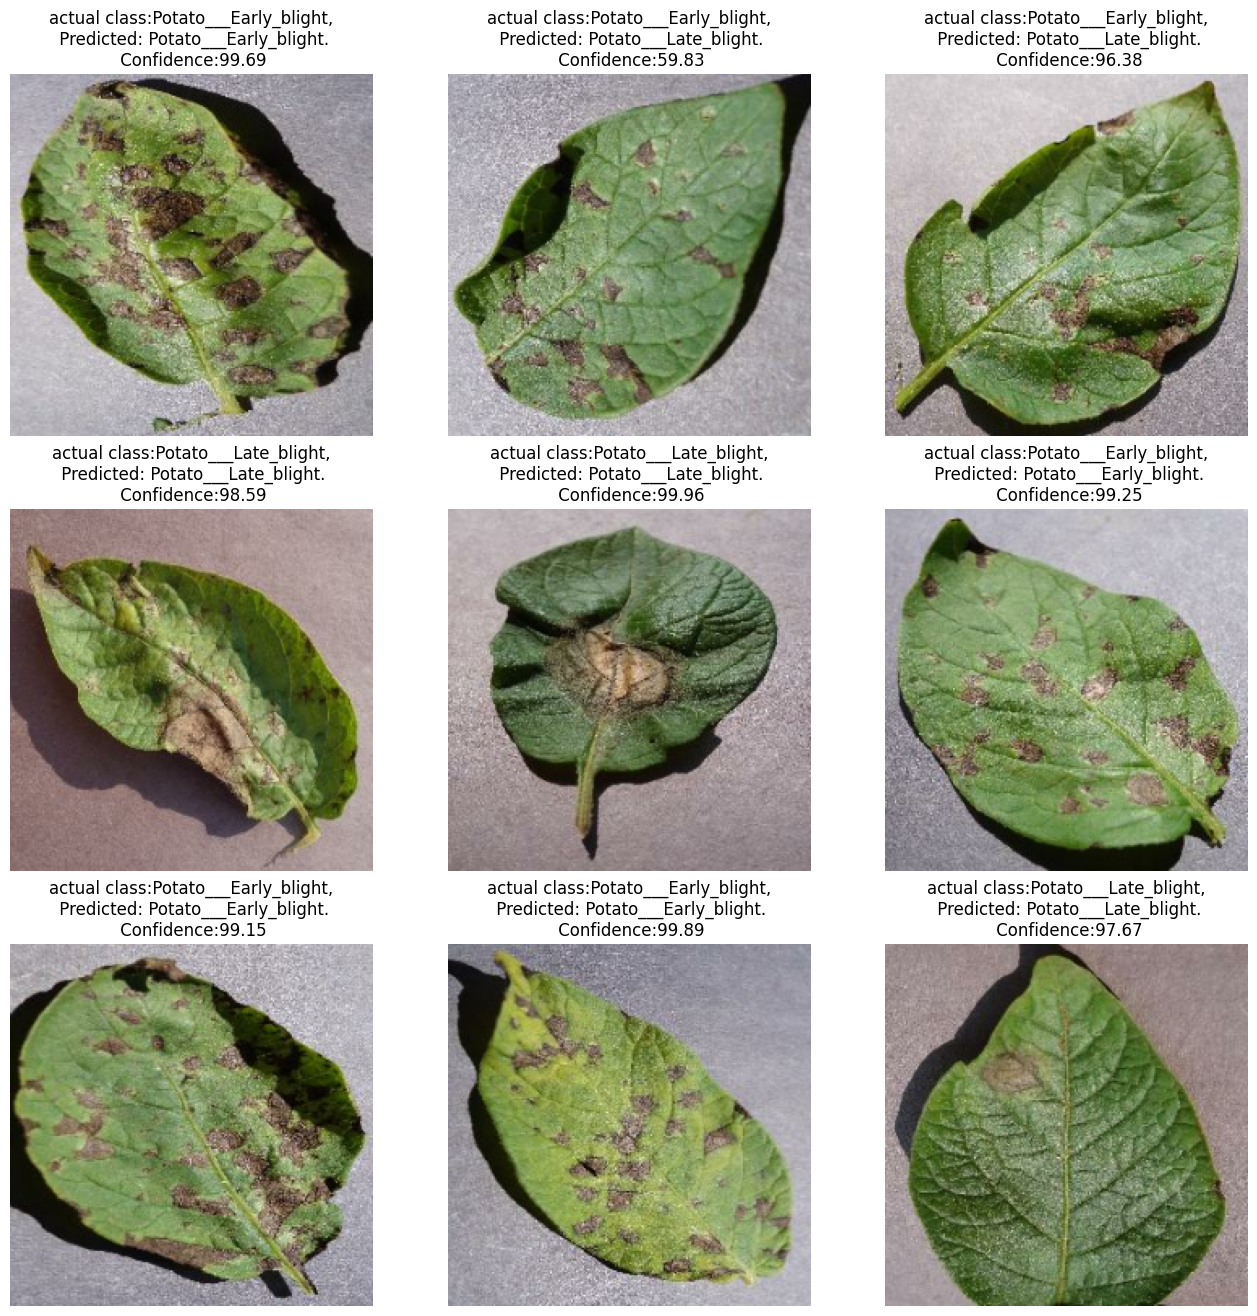

In [51]:
plt.figure(figsize=(16,16))
for images,labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    predicted_class,confidence = predict(model,images[i].numpy())
    actual_class = class_names[labels[i]]
    plt.title(f"actual class:{actual_class},\n Predicted: {predicted_class}.\n Confidence:{confidence}")
    plt.axis('off')

In [57]:
model_version = 1
model.save(f"/content/drive/MyDrive/POTATO DISEASE/saved_models/model{model_version}")